In [1]:
import os
import sys
import pandas as pd
sys.path.append("../")
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = (
    SparkSession.builder.appName("local")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/09/24 07:59:42 WARN Utils: Your hostname, Khues-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.16.46.164 instead (on interface en0)
24/09/24 07:59:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 07:59:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
consumer_details = spark.read.parquet("../data/tables/synthetic/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/synthetic/tbl_merchants.parquet")
consumer_fraud = spark.read.csv("../data/tables/synthetic/consumer_fraud_probability.csv", header=True, inferSchema=True)
merchants_fraud = pd.read_csv("../data/tables/synthetic/merchant_fraud_probability.csv")
consumer = pd.read_csv("../data/tables/synthetic/tbl_consumer.csv")


In [4]:
transactions = spark.read.parquet("../data/tables/synthetic/transactions/*.parquet")

## Transactions dataset

Include the orderdate time details into the transactions dataset.

In [5]:
transactions = transactions.withColumn('order_datetime', F.split(F.input_file_name(), "/")[12])
transactions_w_time = transactions.withColumn('order_datetime', F.substring(F.col('order_datetime'), 1, 10))

In [6]:
# change the datatype from string to date
transactions_w_time = transactions_w_time.withColumn('order_datetime', F.to_date(F.col('order_datetime')))

In [7]:
transactions_w_time.count()

14195505

In [8]:
# join each transaction with probability of fraud
transactions_fraud = transactions_w_time.join(consumer_fraud, on = ['user_id', 'order_datetime'], how = 'outer')

In [31]:
print(transactions_fraud.filter(transactions_fraud['user_id'].isNull()).count())
print(transactions_fraud.filter(transactions_fraud['order_datetime'].isNull()).count())
print(transactions_fraud.filter(transactions_fraud['merchant_abn'].isNull()).count())
print(transactions_fraud.filter(transactions_fraud['dollar_value'].isNull()).count())
print(transactions_fraud.filter(transactions_fraud['order_id'].isNull()).count())
print(transactions_fraud.filter(transactions_fraud['fraud_probability'].isNull()).count())

0


0


0


0


0


14115157


In [9]:
transactions_fraud

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=28191Kb max_used=28490Kb free=102880Kb
 bounds [0x0000000106344000, 0x0000000107f54000, 0x000000010e344000]
 total_blobs=11821 nmethods=10826 adapters=908
 compilation: disabled (not enough contiguous free space left)


user_id,order_datetime,merchant_abn,dollar_value,order_id,fraud_probability
1,2021-03-11,86578477987,23.300617635489033,661ed6fb-c52f-4c5...,NULL
1,2021-03-21,72472909171,26.84427554025195,02627b89-1d59-476...,NULL
1,2021-03-21,86010199872,218.49116722954264,1554c198-01aa-4a8...,NULL
1,2021-05-03,83893827922,2848.168589428446,41fa3fa4-7988-4a6...,NULL
1,2021-05-03,46804135891,67.09721885094145,c3dcb1b2-54d4-47f...,NULL
1,2021-05-12,32234779638,77.68589068822394,0f8d252d-79e0-48e...,NULL
1,2021-05-12,58392414752,77.59241393534961,23a7b399-3399-400...,NULL
1,2021-05-16,80324045558,100.7884172212041,dd8e06be-113c-4b8...,NULL
1,2021-05-20,49505931725,79.89116533221068,faa38b1e-729d-490...,NULL
1,2021-05-20,83690644458,102.77148602868758,68195b1a-e3cb-4b8...,NULL


## Fraud probability imputation

Because we are missing fraud probability for a lot of the transactions, we will use imputation to predict the fraud probability.

In [10]:
# Train dataset
transactions_fraud_train = transactions_fraud.dropna(subset=['fraud_probability'])
transactions_fraud_train.count()

80560

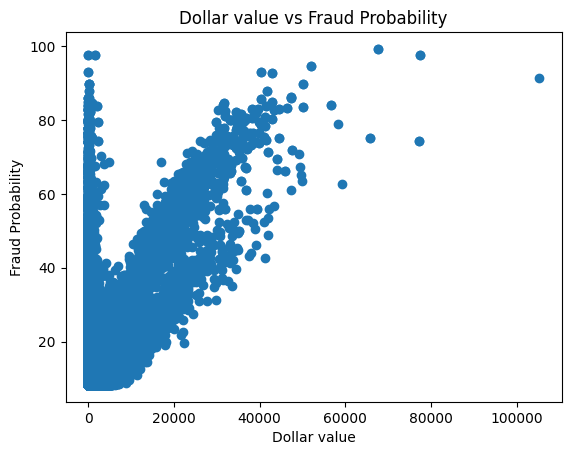

In [11]:
value_fraud = transactions_fraud_train.select('dollar_value', 'fraud_probability').toPandas()

# Create a scatter plot
plt.scatter(value_fraud['dollar_value'], value_fraud['fraud_probability'])

# Add labels and title
plt.xlabel('Dollar value')
plt.ylabel('Fraud Probability')
plt.title('Dollar value vs Fraud Probability')

# Show the plot
plt.show()

In [12]:
value_fraud.sort_values(by='dollar_value', ascending=True).head(1000)

,dollar_value,fraud_probability
72818,0.004564,11.803303
31947,0.006608,9.217225
48243,0.008353,23.137521
44368,0.008946,9.755104
75412,0.011362,9.219662
...,...,...
22182,2.767614,9.776301
28658,2.770998,12.624917
27146,2.774485,20.739332
79628,2.774596,10.710494


In [13]:
assembler = VectorAssembler(inputCols=['dollar_value'], outputCol='features')

transactions_fraud_train_assembled = assembler.transform(transactions_fraud_train)

rf = RandomForestRegressor(featuresCol='features', labelCol='fraud_probability')
rf_model = rf.fit(transactions_fraud_train_assembled)

predictions = rf_model.transform(transactions_fraud_train_assembled)

In [14]:
evaluator_mse = RegressionEvaluator(labelCol='fraud_probability', predictionCol='prediction', metricName='mse')
evaluator_r2 = RegressionEvaluator(labelCol='fraud_probability', predictionCol='prediction', metricName='r2')

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 63.604495727734374
R² Score: 0.3200693824564268


Now we will predict the fraud probabilities for transactions that does not have fraud probabilities.

In [17]:
transactions_fraud_predict = transactions_fraud.filter(transactions_fraud['fraud_probability'].isNull())

In [18]:
transactions_fraud_predict_assembled = assembler.transform(transactions_fraud_predict)
transactions_fraud_predictions = rf_model.transform(transactions_fraud_predict_assembled)

In [20]:
transactions_fraud_predictions = transactions_fraud_predictions.drop('fraud_probability', 'features')

In [22]:
transactions_fraud_predictions = transactions_fraud_predictions.withColumnRenamed('prediction', 'fraud_probability')

In [23]:
transactions_fraud_full = transactions_fraud_train.union(transactions_fraud_predictions)

In [24]:
transactions_fraud_full.count()

14195717

In [25]:
transactions_fraud.count()

14195717

In [26]:
print(transactions_fraud_full.filter(transactions_fraud_full['fraud_probability'].isNull()).count())

0


In [27]:
transactions_fraud_full

user_id,order_datetime,merchant_abn,dollar_value,order_id,fraud_probability
22239,2021-10-19,67264251405,51876.637563877644,09206be9-492c-414...,94.70342477508035
5965,2021-11-14,11149063370,43965.46355720679,fdb38c15-1057-47c...,69.37164467869053
10897,2021-11-11,21807339153,19.468458703644316,1ef2bd85-66ae-48b...,71.27699927869216
10897,2021-11-11,19010030815,41999.00172659059,eecbf18b-ec14-4eb...,71.27699927869216
6383,2021-09-15,34920839316,22.898167875482013,3c4dad98-290d-47e...,66.2676451623754
6383,2021-09-15,14530561097,46001.13901942742,00f150fa-dc82-43d...,66.2676451623754
3101,2021-04-17,91880575299,105193.88578925544,2ab65c8f-11b2-41c...,91.42192091901347
10278,2021-09-28,19010030815,50066.19010321954,a4c05e01-c882-4b5...,83.59136689427714
6436,2021-12-24,32234779638,5.114758684774464,46f153c4-5022-492...,84.81618344606828
6436,2021-12-24,19010030815,42871.324786685116,d37ca9ea-1436-426...,84.81618344606828


## Merchants dataset cleaning

Since there are 3 values store in the 'tags' column, we will split them into 3 separate columns for analysis.

In [29]:
merchants_lower = merchants.withColumn('tags', F.lower(merchants['tags'])) \
                        .withColumn('name', F.lower(merchants['name']))

In [31]:
merchants_lower = merchants_lower.withColumn('tags', F.regexp_replace('tags', r'\[', '('))
merchants_lower = merchants_lower.withColumn('tags', F.regexp_replace('tags', r'\]', ')'))

In [35]:
merchants_split = merchants_lower.withColumn('type', F.split(merchants_lower['tags'], r'\), \(').getItem(0)) \
                                   .withColumn('rev_level', F.split(merchants_lower['tags'], r'\), \(').getItem(1)) \
                                   .withColumn('take_rate', F.split(merchants_lower['tags'], r'\), \(').getItem(2))

In [36]:
merchants_split = merchants_split.drop('tags')

In [38]:
merchants_split = merchants_split.withColumn('type', F.regexp_replace('type', r'\(\(', ''))

merchants_split = merchants_split.withColumn('take_rate', F.regexp_replace('take_rate', r'\)\)', ''))
merchants_split = merchants_split.withColumn('take_rate', F.regexp_replace('take_rate', r'take rate: ', ''))
merchants_split = merchants_split.withColumn('take_rate', merchants_split['take_rate'].cast('float'))


In [41]:
merchants_split

name,merchant_abn,type,rev_level,take_rate
felis limited,10023283211,"furniture, home f...",e,0.18
arcu ac orci corp...,10142254217,"cable, satellite,...",b,4.22
nunc sed company,10165489824,"jewelry, watch, c...",b,4.4
ultricies digniss...,10187291046,"watch, clock, and...",b,3.29
enim condimentum pc,10192359162,music shops - mus...,a,6.33
fusce company,10206519221,"gift, card, novel...",a,6.34
aliquam enim inco...,10255988167,"computers, comput...",b,4.32
ipsum primis ltd,10264435225,"watch, clock, and...",c,2.39
pede ultrices ind...,10279061213,computer programm...,a,5.71
nunc inc.,10323485998,"furniture, home f...",a,6.61


## Transaction and Merchants dataset merge

In [55]:
transactions_w_merchants_details = transactions_fraud_full.join(merchants_split, on='merchant_abn')

In [56]:
transactions_w_merchants_details.dtypes

[('merchant_abn', 'bigint'),
 ('user_id', 'bigint'),
 ('order_datetime', 'date'),
 ('dollar_value', 'double'),
 ('order_id', 'string'),
 ('fraud_probability', 'double'),
 ('name', 'string'),
 ('type', 'string'),
 ('rev_level', 'string'),
 ('take_rate', 'float')]

In [59]:
transactions_w_merchants_details = transactions_w_merchants_details.withColumn(
    'expected_revenue', (F.col('take_rate')/100) * F.col('dollar_value') * (1 - (F.col('fraud_probability')/100)))
transactions_w_merchants_details = transactions_w_merchants_details.withColumn(
    'expected_loss', ((F.col('fraud_probability')/100) * F.col('dollar_value'))
)  
transactions_w_merchants_details = transactions_w_merchants_details.withColumn(
    'expected_profit', (F.col('expected_revenue') - F.col('expected_loss'))
)    

In [60]:
transactions_w_merchants_details

merchant_abn,user_id,order_datetime,dollar_value,order_id,fraud_probability,name,type,rev_level,take_rate,expected_revenue,expected_loss,expected_profit
43725628716,58,2021-11-26,2684.361417897887,52133cb6-4950-44c...,9.241197906604826,proin velit sed l...,"hobby, toy and ga...",a,5.53,134.7270780623482,248.06715115648717,-113.34007309413897
45629217853,58,2021-11-26,0.19607762574988435,e5b1880d-fb88-4fd...,9.241197906604826,lacus consulting,"gift, card, novel...",a,6.98,0.012421447794345576,0.01811992144611876,-0.00569847365177...
73499119023,58,2021-11-26,9.260984119033456,a576a634-dcd0-445...,9.241197906604826,nisi dictum company,"watch, clock, and...",a,5.56,0.4673267938068147,0.8558258705391252,-0.3884990767323105
30623214058,69,2021-11-26,111.91165017514544,362fc544-e9c0-449...,15.645332445256162,mauris eu pc,"gift, card, novel...",c,2.06,1.9446955754639415,17.508949714873605,-15.564254139409664
79417999332,69,2021-11-26,54.89560911946132,3c246238-a15f-429...,15.645332445256162,phasellus at company,"gift, card, novel...",b,4.95,2.2921968361326157,8.588600544588083,-6.2964037084554665
18305506006,69,2021-11-26,5.198633525613379,e4cb215d-26d8-4e4...,15.645332445256162,mollis lectus con...,"watch, clock, and...",a,6.25,0.274080626745039,0.8133434976927543,-0.5392628709477152
96244711717,69,2021-11-26,52.48791119040359,3a3c80b1-be38-447...,15.645332445256162,cras sed leo corp.,"gift, card, novel...",a,6.44,2.8513746179613944,8.211908199309454,-5.36053358134806
16248082282,69,2021-11-26,361.5545523024534,8f448a5a-fe7c-4fc...,15.645332445256162,phasellus foundation,health and beauty...,a,6.8,20.739194144135546,56.5664116786764,-35.82721753454086
45629217853,15039,2021-11-26,26.34821606933028,99c767d9-811b-4cd...,19.10895425125948,lacus consulting,"gift, card, novel...",a,6.98,1.4876716605856017,5.0348685547113226,-3.5471968941257206
38990495653,15039,2021-11-26,5960.306286114107,eff74b08-7f2f-41c...,19.10895425125948,ut molestie in co...,"furniture, home f...",a,6.83,329.2984803042606,1138.9522014484876,-809.653721144227


## Aggregatation

In [61]:
aggregated_df = transactions_w_merchants_details.groupBy('merchant_abn', 'name', 'type', 'rev_level', 'take_rate').agg(
    F.count('user_id').alias('customer_count'),
    F.count('order_id').alias('transaction_count'),
    F.sum('dollar_value').alias('total_spent'), 
    F.sum('expected_profit').alias('total_profit')
)

In [65]:
aggregated_df.orderBy(F.col('total_profit').desc())

24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/09/24 08:58:11 WARN RowBasedKeyValueBatch: Calling spill() on

merchant_abn,name,type,rev_level,take_rate,customer_count,transaction_count,total_spent,total_profit
52266154043,lobortis tellus j...,art dealers and g...,a,6.88,7,7,10766.028035085252,-439.6841876355994
17507773571,libero nec limited,"hobby, toy and ga...",a,5.89,7,7,10622.91570745655,-587.5085247984447
29681526553,cras vehicula ali...,tent and awning s...,a,6.24,22,22,10321.148053029814,-658.8194918737162
94110063346,magna praesent in...,"hobby, toy and ga...",a,6.37,9,9,11970.246880413251,-676.1400812838274
32350997564,donec vitae corpo...,lawn and garden s...,a,6.74,10,10,13182.168179720782,-684.4751497343146
27207000299,egestas sed phare...,bicycle shops - s...,a,5.84,10,10,11017.784769901533,-722.1466641341476
61569154734,blandit at nisi pc,tent and awning s...,a,5.78,12,12,11606.65195572256,-764.546766314186
38523766800,elit elit ferment...,"furniture, home f...",a,5.94,8,8,11802.522561477143,-821.199216474439
17175760321,morbi metus vivam...,"hobby, toy and ga...",a,6.33,13,13,17046.030665293885,-824.117397403025
47864961615,enim mi corp.,bicycle shops - s...,a,6.87,11,11,15702.556585101202,-828.9133456963762


In [66]:
aggregated_df.count()

4026

In [67]:
merchants_split.count()

4026

Anything below this are snippets of code that I do not want to delete for now.

---------------------------------------------------------------------------------------------------------------------------

## Consumer

In [5]:
consumer_fraud

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
...,...,...,...
34859,18466,2022-02-22,8.679873
34860,17552,2021-12-26,8.349463
34861,17875,2021-06-27,8.288847
34862,10401,2021-09-18,8.842216


In [4]:
consumer_details.describe() #transaction made by 24081 user_id

summary,user_id,consumer_id
count,499999,499999
mean,250000.0,750895.2123184246
stddev,144337.422959767,433100.42601411033
min,1,4
max,499999,1499995


In [5]:
consumer_fraud.describe()

,user_id,fraud_probability
count,34864.000000,34864.000000
mean,12057.003930,15.120091
std,6963.195641,9.946085
min,1.000000,8.287144
25%,6059.750000,9.634437
50%,12067.500000,11.735624
75%,18091.250000,16.216158
max,24081.000000,99.247380


In [6]:
consumer[['name', 'address', 'state', 'postcode', 'gender', 'consumer_id']] = consumer['name|address|state|postcode|gender|consumer_id'].str.split('|', expand=True)
consumer = consumer.drop(columns=['name|address|state|postcode|gender|consumer_id'])

In [7]:
consumer.dtypes

name           object
address        object
state          object
postcode       object
gender         object
consumer_id    object
dtype: object

In [8]:
consumer['consumer_id'] = consumer['consumer_id'].astype(int)
consumer['postcode'] = consumer['postcode'].astype(int)
consumer['state_encoded'] = LabelEncoder().fit_transform(consumer['state'])
consumer['gender_encoded'] = LabelEncoder().fit_transform(consumer['gender'])

In [52]:
consumer_fraud['user_id'].nunique()

20128

In [9]:
consumer.dtypes

name              object
address           object
state             object
postcode           int64
gender            object
consumer_id        int64
state_encoded      int64
gender_encoded     int64
dtype: object

The list of merchants from merchants_df is less than the number of merchants shown in the transaction

In [10]:
details = pd.merge(consumer_details.toPandas(), consumer, on='consumer_id', how='outer')
details

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=24990Kb max_used=24990Kb free=106081Kb
 bounds [0x000000010213c000, 0x00000001039cc000, 0x000000010a13c000]
 total_blobs=10420 nmethods=9427 adapters=905
 compilation: disabled (not enough contiguous free space left)


,user_id,consumer_id,name,address,state,postcode,gender,state_encoded,gender_encoded
0,108417,4,Michele Kelley,28656 Sims Plaza Suite 036,NSW,2774,Female,1,0
1,371406,7,James Williams,3709 Mary River,TAS,7248,Male,5,1
2,167772,9,Timothy Ramos,290 Melissa Point Apt. 123,QLD,4694,Male,3,1
3,137864,10,Beth Mendoza,5002 Meredith Views,QLD,4426,Female,3,0
4,92127,19,Dennis Ramirez,20761 Matthews Via Apt. 694,QLD,4406,Male,3,1
...,...,...,...,...,...,...,...,...,...
499994,419774,1499983,Juan Sims,15168 Jones Row,WA,6054,Male,7,1
499995,25039,1499984,Jenna Serrano,53746 Kenneth Avenue,NSW,1740,Female,1,0
499996,396464,1499985,Alyssa Myers,047 William Plain Suite 431,NSW,2549,Undisclosed,1,2
499997,46172,1499986,Emily Turner,8118 Kimberly Estate Apt. 757,QLD,4475,Female,3,0


In [11]:
consumer_full = pd.merge(details, consumer_fraud, on='user_id', how='outer')
consumer_full['user_id'].nunique()

499999

In [12]:
consumer_full[consumer_full.isnull().any(axis=1)].count()

user_id              479871
consumer_id          479871
name                 479871
address              479871
state                479871
postcode             479871
gender               479871
state_encoded        479871
gender_encoded       479871
order_datetime            0
fraud_probability         0
dtype: int64

In [19]:
consumer_full.dtypes

user_id                int64
consumer_id            int64
name                  object
address               object
state                 object
postcode               int64
gender                object
state_encoded          int64
gender_encoded         int64
order_datetime        object
fraud_probability    float64
dtype: object

In [20]:
consumer_full = consumer_full.set_index('user_id')

In [37]:
trans_by_user = transactions.groupBy('user_id') \
                    .agg(
                        F.count('order_id').alias('order_count'),
                        F.sum('dollar_value').alias('total_dollar_value'),
                    )
trans_by_user_pd = trans_by_user.toPandas()
trans_by_user_pd = trans_by_user_pd.set_index('user_id')
trans_by_user_pd['avg_dollar_value'] = trans_by_user_pd['total_dollar_value']/trans_by_user_pd['order_count']

In [51]:
transactions.select(F.countDistinct("user_id")).collect()[0][0]

24081

In [40]:
consumer_trans = pd.merge(consumer_full, trans_by_user_pd, on='user_id', how='outer')
consumer_trans

,consumer_id,name,address,state,postcode,gender,state_encoded,gender_encoded,order_datetime,fraud_probability,order_count,total_dollar_value,avg_dollar_value
user_id,,,,,,,,,,,,,
1,1195503,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,7,0,2022-02-20,9.805431,584.0,94927.163969,162.546514
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-09-25,10.069851,585.0,123953.506822,211.886336
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-08-30,9.599514,585.0,123953.506822,211.886336
3,1194530,Jill Jones MD,40693 Henry Greens,NT,862,Female,2,0,2021-11-03,8.300636,587.0,97035.322010,165.307193
4,154128,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,1,0,2021-10-09,9.633302,593.0,87592.252770,147.710376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1385608,Jessica Avila,508 Miranda Overpass Apt. 218,QLD,4400,Female,3,0,NaN,NaN,NaN,NaN,NaN
499996,1466964,Steven Thornton,7913 Schwartz Mission Suite 483,VIC,3097,Undisclosed,6,2,NaN,NaN,NaN,NaN,NaN
499997,1253484,Christy Smith,5681 Zachary Mountain Apt. 060,NSW,2756,Undisclosed,1,2,NaN,NaN,NaN,NaN,NaN


## Fraud prob

In [41]:
consumer_filtered = consumer_trans.dropna(subset=['fraud_probability'])
consumer_filtered

,consumer_id,name,address,state,postcode,gender,state_encoded,gender_encoded,order_datetime,fraud_probability,order_count,total_dollar_value,avg_dollar_value
user_id,,,,,,,,,,,,,
1,1195503,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,7,0,2022-02-20,9.805431,584.0,94927.163969,162.546514
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-09-25,10.069851,585.0,123953.506822,211.886336
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-08-30,9.599514,585.0,123953.506822,211.886336
3,1194530,Jill Jones MD,40693 Henry Greens,NT,862,Female,2,0,2021-11-03,8.300636,587.0,97035.322010,165.307193
4,154128,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,1,0,2021-10-09,9.633302,593.0,87592.252770,147.710376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24079,256441,Tony Schmidt,670 Burke Turnpike Apt. 079,VIC,3029,Male,6,1,2021-09-12,9.721157,594.0,122228.006616,205.771055
24079,256441,Tony Schmidt,670 Burke Turnpike Apt. 079,VIC,3029,Male,6,1,2021-11-08,8.940524,594.0,122228.006616,205.771055
24079,256441,Tony Schmidt,670 Burke Turnpike Apt. 079,VIC,3029,Male,6,1,2021-11-26,8.838622,594.0,122228.006616,205.771055


In [42]:
consumer_filtered_1 = consumer_filtered.groupby(['user_id', 'order_count', 'total_dollar_value', 'avg_dollar_value']) \
                                .agg(avg_fraud_prob=('fraud_probability', 'mean')).reset_index()
consumer_filtered_1

,user_id,order_count,total_dollar_value,avg_dollar_value,avg_fraud_prob
0,1,584.0,94927.163969,162.546514,9.805431
1,2,585.0,123953.506822,211.886336,9.834682
2,3,587.0,97035.322010,165.307193,8.300636
3,4,593.0,87592.252770,147.710376,9.633302
4,5,609.0,94880.476559,155.797170,15.794925
...,...,...,...,...,...
20123,24075,580.0,97195.068007,167.577703,18.463737
20124,24076,596.0,106311.225711,178.374540,15.657614
20125,24078,580.0,93378.017587,160.996582,15.048298
20126,24079,594.0,122228.006616,205.771055,10.612117


In [45]:
X = consumer_filtered_1.drop(['user_id', 'avg_fraud_prob'], axis=1)  # features
y = consumer_filtered_1['avg_fraud_prob']  # target

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}, Test size: {X_test.shape}")

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE) and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Training size: (16102, 3), Test size: (4026, 3)
Mean Squared Error: 78.32019729220906
R^2 Score: 0.16217618591106464


In [46]:
consumer_wo_p = consumer_full.drop(['consumer_id', 'name', 'address', 'state', 'gender'], axis=1)

In [47]:
consumer_wo_p_1 = consumer_wo_p[consumer_wo_p['fraud_probability'].isna()].drop(['order_datetime', 'fraud_probability'], axis=1)
consumer_wo_p_1

,postcode,state_encoded,gender_encoded
user_id,,,
7,4606,3,0
8,6056,7,1
10,3220,6,0
11,3063,6,2
12,6743,7,0
...,...,...,...
499995,4400,3,0
499996,3097,6,2
499997,2756,1,2


In [48]:
consumer_wo_p_1['avg_fraud_prob'] = model.predict(consumer_wo_p_1.drop('user_id', axis=1))
consumer_wo_p_1

KeyError: "['user_id'] not found in axis"

In [ ]:
pd.concat([consumer_wo_p_1, consumer_filtered_1], ignore_index=True)

## Transactions

,consumer_id,name,address,state,postcode,gender,state_encoded,gender_encoded,order_datetime,fraud_probability,order_count,total_dollar_value,avg_dollar_value
user_id,,,,,,,,,,,,,
1,1195503,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,7,0,2022-02-20,9.805431,584,94927.163969,162.546514
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-09-25,10.069851,585,123953.506822,211.886336
2,179208,Mary Smith,3764 Amber Oval,NSW,2782,Female,1,0,2021-08-30,9.599514,585,123953.506822,211.886336
3,1194530,Jill Jones MD,40693 Henry Greens,NT,862,Female,2,0,2021-11-03,8.300636,587,97035.322010,165.307193
4,154128,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,1,0,2021-10-09,9.633302,593,87592.252770,147.710376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24079,256441,Tony Schmidt,670 Burke Turnpike Apt. 079,VIC,3029,Male,6,1,2021-11-08,8.940524,594,122228.006616,205.771055
24079,256441,Tony Schmidt,670 Burke Turnpike Apt. 079,VIC,3029,Male,6,1,2021-11-26,8.838622,594,122228.006616,205.771055
24080,940951,Amy Russo,4525 Frazier Meadows,NSW,2809,Female,1,0,NaN,NaN,591,88638.274060,149.980159


## Merchants + take rate

In [20]:
merchants_1 = merchants.withColumn('tags', F.lower(merchants['tags'])) \
                        .withColumn('name', F.lower(merchants['name'])).toPandas()
merchants_1['tags'] = merchants_1['tags'].str.replace('[', '(').str.replace(']', ')')
merchants_1['tags'] = merchants_1['tags'].astype('string')
merchants_1[['type', 'rev_level', 'take_rate']] = merchants_1['tags'].str.split(r'\), \(', expand=True)
merchants_1 = merchants_1.drop(columns=['tags'])
merchants_1['type'] = merchants_1['type'].str.replace('((', '', regex=False)
merchants_1['take_rate'] = merchants_1['take_rate'].str.replace('))', '', regex=False).str.replace('take rate: ', '', regex=False).astype(float)
merchants_1.dtypes

In [21]:
merchants_1['tags'] = merchants_1['tags'].str.replace('[', '(').str.replace(']', ')')
merchants_1['tags'] = merchants_1['tags'].astype('string')

In [22]:
merchants_1[['type', 'rev_level', 'take_rate']] = merchants_1['tags'].str.split(r'\), \(', expand=True)
merchants_1 = merchants_1.drop(columns=['tags'])

In [23]:
merchants_1['type'] = merchants_1['type'].str.replace('((', '', regex=False)
merchants_1['take_rate'] = merchants_1['take_rate'].str.replace('))', '', regex=False).str.replace('take rate: ', '', regex=False).astype(float)

In [24]:
merchants_1.dtypes

name                    object
merchant_abn             int64
type            string[python]
rev_level       string[python]
take_rate              float64
dtype: object

In [28]:
transactions = transactions.withColumn('merchant_abn', F.col('merchant_abn').cast('int'))
transactions.dtypes

[('user_id', 'bigint'),
 ('merchant_abn', 'int'),
 ('dollar_value', 'double'),
 ('order_id', 'string')]

In [30]:
merchants_1

,name,merchant_abn,type,rev_level,take_rate
0,felis limited,10023283211,"furniture, home furnishings and equipment shop...",e,0.18
1,arcu ac orci corporation,10142254217,"cable, satellite, and other pay television and...",b,4.22
2,nunc sed company,10165489824,"jewelry, watch, clock, and silverware shops",b,4.40
3,ultricies dignissim lacus foundation,10187291046,"watch, clock, and jewelry repair shops",b,3.29
4,enim condimentum pc,10192359162,"music shops - musical instruments, pianos, and...",a,6.33
...,...,...,...,...,...
4021,elit dictum eu ltd,99938978285,"opticians, optical goods, and eyeglasses",b,4.50
4022,mollis llp,99974311662,"books, periodicals, and newspapers",b,3.17
4023,sociosqu corp.,99976658299,shoe shops,a,6.57
4024,commodo hendrerit llc,99987905597,motor vehicle supplies and new parts,a,6.82


In [31]:
transactions

user_id,merchant_abn,dollar_value,order_id
14935,2108588004,136.06570809815838,23acbb7b-cf98-458...
1,-793091288,72.61581642788431,76bab304-fa2d-400...
14936,-675683599,3.0783487174439297,a2ae446a-2959-41c...
1,1922891469,51.58228625503599,7080c274-17f7-4cc...
14936,1036349571,25.228114942417797,8e301c0f-06ab-45c...
2,-741004848,691.5028234458998,0380e9ad-b0e8-420...
14936,826914280,102.13952056640888,5ac3da9c-5147-452...
2,399556458,644.5220654863093,4e368e44-86f8-4de...
14938,994852201,209.12780951421405,4d78cd01-4bab-494...
3,-1792138759,141.0387993699113,c50c957d-ecfc-430...


In [29]:
merchants_trans = merchants_1.join(transactions, on='merchant_abn')
merchants_trans

ValueError: Joining multiple DataFrames only supported for joining on index

In [42]:
merchants_trans_1 = merchants_trans \
                    .groupBy('name', 'tags', 'merchant_abn') \
                    .agg(
                        F.count('order_id').alias('order_count'),
                        F.sum('dollar_value').alias('total_dollar_value'),
                    )
merchants_trans_1

name,tags,merchant_abn,order_count,total_dollar_value
eget lacus llp,"[[cable, satellit...",47663262928,10422,1013371.6659596296
arcu vestibulum c...,"((hobby, toy and ...",17158952809,20258,1269279.4663547624
arcu iaculis corp...,"([shoe shops], [a...",10955677986,754,176773.53578258128
mauris aliquam eu...,"([cable, satellit...",75720304166,578,44868.54430167646
vel pede blandit ...,"((opticians, opti...",52535771754,4177,1184849.041883478
pretium neque inc.,([tent and awning...,77013874702,3448,46572.26047940074
nullam scelerisqu...,"[(opticians, opti...",78663389603,978,87128.57419733977
eget llc,"[(stationery, off...",49514072231,1647,1204279.1570783928
diam sed inc.,[[computer progra...,25607153542,461,45733.82825409439
donec dignissim m...,"((telecom), (c), ...",95938358124,126,235756.5269952945


In [45]:
merchants_trans_1 = merchants_trans_1.withColumn('spent_per_order', F.col('total_dollar_value') / F.col('order_count'))


In [46]:
merchants_trans_1.dropDuplicates(subset=['name', 'tags', 'merchant_abn'])
merchants_trans_1.count() #no duplicate merchants

4026

In [50]:
fraud = pd.merge(merchants_trans_1.toPandas(), merchants_fraud, on='merchant_abn')
fraud

,name,tags,merchant_abn,order_count,total_dollar_value,spent_per_order,order_datetime,fraud_probability
0,dictum phasellus in institute,"[(gift, card, novelty, and souvenir shops), (a...",94493496784,99176,9.115636e+06,91.913728,2021-11-26,30.579032
1,lacus aliquam corporation,"[(antique shops - sales, repairs, and restora...",31334588839,1527,9.630683e+06,6306.930472,2021-10-02,42.755301
2,lacus aliquam corporation,"[(antique shops - sales, repairs, and restora...",31334588839,1527,9.630683e+06,6306.930472,2021-12-26,38.361660
3,lacus aliquam corporation,"[(antique shops - sales, repairs, and restora...",31334588839,1527,9.630683e+06,6306.930472,2021-11-26,36.209713
4,lacus aliquam corporation,"[(antique shops - sales, repairs, and restora...",31334588839,1527,9.630683e+06,6306.930472,2021-11-29,35.386213
...,...,...,...,...,...,...,...,...
90,pharetra quisque company,"([jewelry, watch, clock, and silverware shops]...",90918180829,557,5.514145e+06,9899.721335,2022-01-27,33.080273
91,pharetra quisque company,"([jewelry, watch, clock, and silverware shops]...",90918180829,557,5.514145e+06,9899.721335,2022-02-19,30.975819
92,nullam enim sed incorporated,"((tent and awning shops), (e), (take rate: 0.27))",78080443264,1099,2.241564e+04,20.396394,2021-11-26,69.095317
93,ornare limited,"([motor vehicle supplies and new parts], [a], ...",96680767841,31134,9.806731e+06,314.984620,2021-11-26,29.555245


In [51]:
fraud_1 = fraud.groupby(['name', 'tags', 'merchant_abn', 'order_count',	'total_dollar_value', 'spent_per_order']) \
                .agg(fraud_count=('order_datetime', 'count'), avg_fraud_prob=('fraud_probability', 'mean'))

fraud_1

,,,,,,fraud_count,avg_fraud_prob
name,tags,merchant_abn,order_count,total_dollar_value,spent_per_order,,
accumsan corporation,"[(jewelry, watch, clock, and silverware shops), (b), (take rate: 4.65)]",86889657711,78,1.160758e+06,14881.517466,1,63.212226
amet risus inc.,"([furniture, home furnishings and equipment shops, and manufacturers, except appliances], [a], [take rate: 6.82])",79827781481,4798,9.734168e+06,2028.797098,2,29.735159
arcu morbi institute,"([artist supply and craft shops], [c], [take rate: 1.47])",39649557865,21919,9.857402e+06,449.719528,1,28.690204
arcu sed eu incorporated,"[(computer programming , data processing, and integrated systems design services), (b), (take rate: 4.80)]",35909341340,37985,9.528214e+06,250.841492,1,29.133053
arcu sed pc,"((antique shops - sales, repairs, and restoration services), (b), (take rate: 4.19))",11590404675,51,8.108893e+05,15899.790936,1,29.607818
arcu vivamus sit limited,"([shoe shops], [a], [take rate: 5.91])",30275989942,235,3.863379e+04,164.399103,1,63.108593
at foundation,"((antique shops - sales, repairs, and restoration services), (b), (take rate: 3.40))",91880575299,33,6.682598e+05,20250.295557,1,32.994978
commodo ipsum industries,"([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.93])",19492220327,824,8.165223e+06,9909.250618,8,31.958307
diam eu dolor llc,"[(tent and awning shops), (b), (take rate: 4.10)]",90568944804,10732,9.618325e+06,896.228525,3,30.722985


In [131]:
merchants_fraud

,merchant_abn,order_datetime,fraud_probability
0,19492220327,2021-11-28,44.403659
1,31334588839,2021-10-02,42.755301
2,19492220327,2021-12-22,38.867790
3,82999039227,2021-12-19,94.134700
4,90918180829,2021-09-02,43.325517
...,...,...,...
109,80089686333,2021-09-01,67.505811
110,83220249221,2021-11-27,63.512459
111,85482742429,2021-11-27,70.881311
112,11470993597,2021-09-28,63.377344


24/09/10 11:30:05 WARN TransportChannelHandler: Exception in connection from /172.20.10.7:64872
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java: